In [1]:
library(tidyverse)
library(magrittr)
library(martini)
library(cowplot)

load(file = "../datasets/genesis/genesis.RData")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: igraph

Attaching package: ‘igraph’

The following object is masked from ‘package:magrittr’:

    %>%

The following objects are masked from ‘package:dplyr’:

    %>%, as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    %>%, compose, simplify

The following objects are masked from ‘package:tidyr’:

    %>%, crossing

The following object is masked from ‘pac

# Data exploration

In [2]:
summary(genesis$genotype)

$rows
   Call.rate Certain.calls Heterozygosity  
 Min.   :1   Min.   :1     Min.   :0.2663  
 1st Qu.:1   1st Qu.:1     1st Qu.:0.3138  
 Median :1   Median :1     Median :0.3161  
 Mean   :1   Mean   :1     Mean   :0.3159  
 3rd Qu.:1   3rd Qu.:1     3rd Qu.:0.3184  
 Max.   :1   Max.   :1     Max.   :0.3290  

$cols
     Calls        Call.rate Certain.calls      RAF           
 Min.   :2566   Min.   :1   Min.   :1     Min.   :0.0009743  
 1st Qu.:2566   1st Qu.:1   1st Qu.:1     1st Qu.:0.1095090  
 Median :2566   Median :1   Median :1     Median :0.2373344  
 Mean   :2566   Mean   :1   Mean   :1     Mean   :0.2882514  
 3rd Qu.:2566   3rd Qu.:1   3rd Qu.:1     3rd Qu.:0.4269291  
 Max.   :2566   Max.   :1   Max.   :1     Max.   :0.9988309  
      MAF                 P.AA             P.AB               P.BB        
 Min.   :0.0009743   Min.   :0.0000   Min.   :0.001949   Min.   :0.00000  
 1st Qu.:0.1069758   1st Qu.:0.3289   1st Qu.:0.190569   1st Qu.:0.01208  
 Median :0.2205768  

In [3]:
snpsum <- col.summary(genesis$genotype)

In [4]:
subject.info <- data.frame(cc = genesis$fam$affected, stratum = rep("EUR", nrow(genesis$fam)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


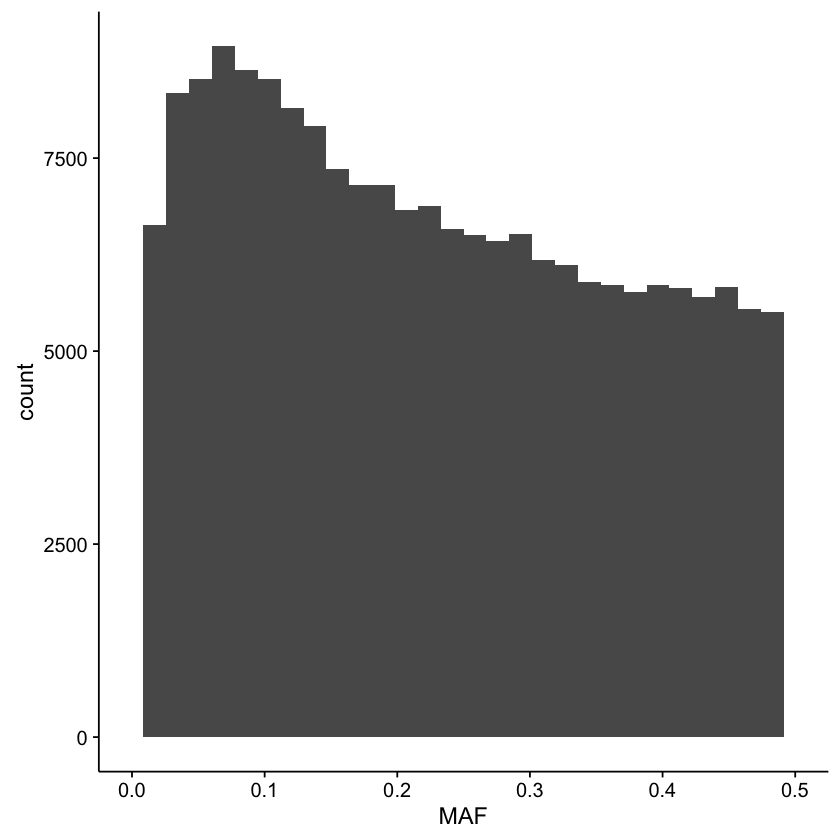

In [5]:
ggplot(snpsum, aes(x = MAF)) + 
    geom_histogram() +
    lims(x = c(0, 0.5))

# GWAS

In [6]:
tests <- single.snp.tests(genesis$fam$affected, 
                          data = subject.info, 
                          snp.data = genesis$genotypes)

tests.info <- genesis$map %>%
    arrange(V1, V4) %>%
    mutate(p = p.value(tests, df=1),
           adjp = p.adjust(p),
           id = paste(V1, V4, sep = "_"), id = factor(id, levels = id),
           chr = as.character(V1), chr = factor(chr, levels = unique(chr)))

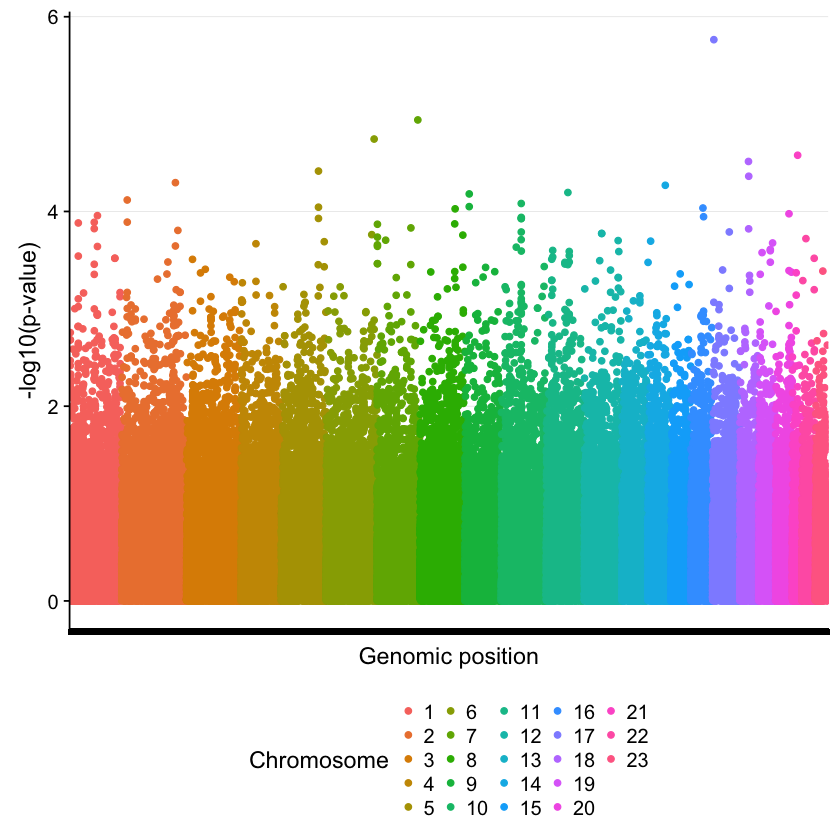

In [7]:
ggplot(tests.info, aes(x = id, y = -log10(p), color = chr)) +
    geom_point() +
    background_grid(major = "y", minor = "none") +
    theme(axis.text.x = element_blank(),
          legend.position = "bottom") +
    labs(x = "Genomic position", y = "-log10(p-value)", color = "Chromosome")

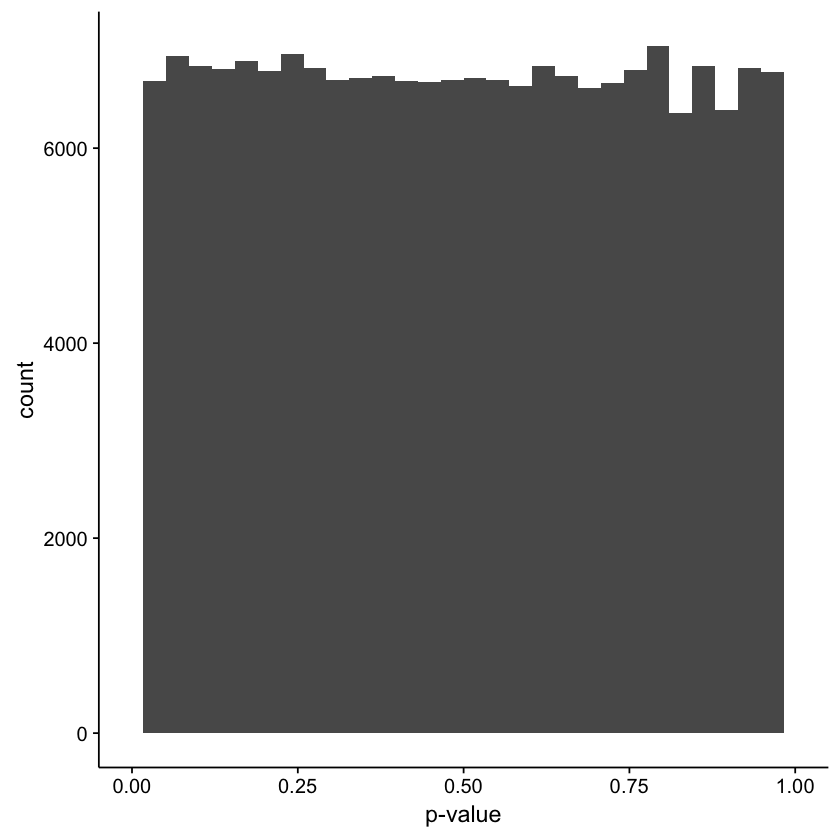

In [8]:
ggplot(tests.info, aes(x = p)) +
    geom_histogram(bins = 30) +
    lims(x = c(0,1)) +
    labs(x = "p-value")

In [9]:
bonferroni.threshold <- 0.05/nrow(genesis$map)
sum(tests.info$p < bonferroni.threshold)

[1] 0

In [10]:
sum(tests.info$adjp < 0.05)

[1] 0

# Population structure

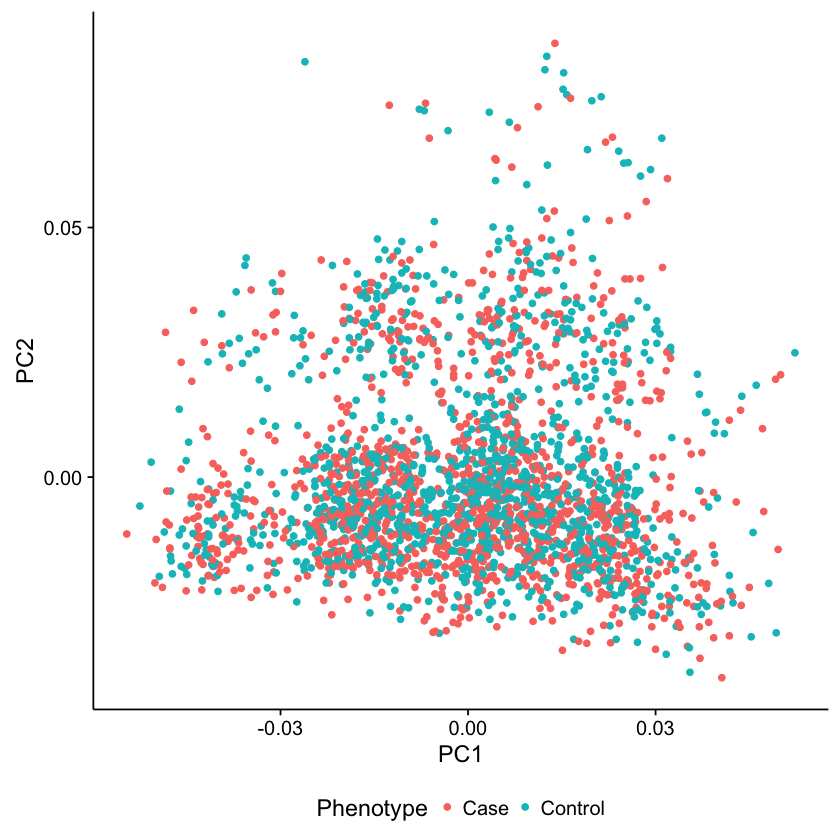

In [11]:
ev <- read.delim("../results/population_structure/genesis.processed.pca.evec", 
                 sep = "", header = F, skip = 1)
ncols <- ncol(ev)
colnames(ev) <- c("sample", paste0("pc", seq(1, ncols - 2)), "phenotype")

ggplot(ev, aes(x = pc1, y = pc2, color = phenotype)) +
    geom_point() +
    labs(x = "PC1", y = "PC2", color = "Phenotype") +
    theme(legend.position = "bottom")

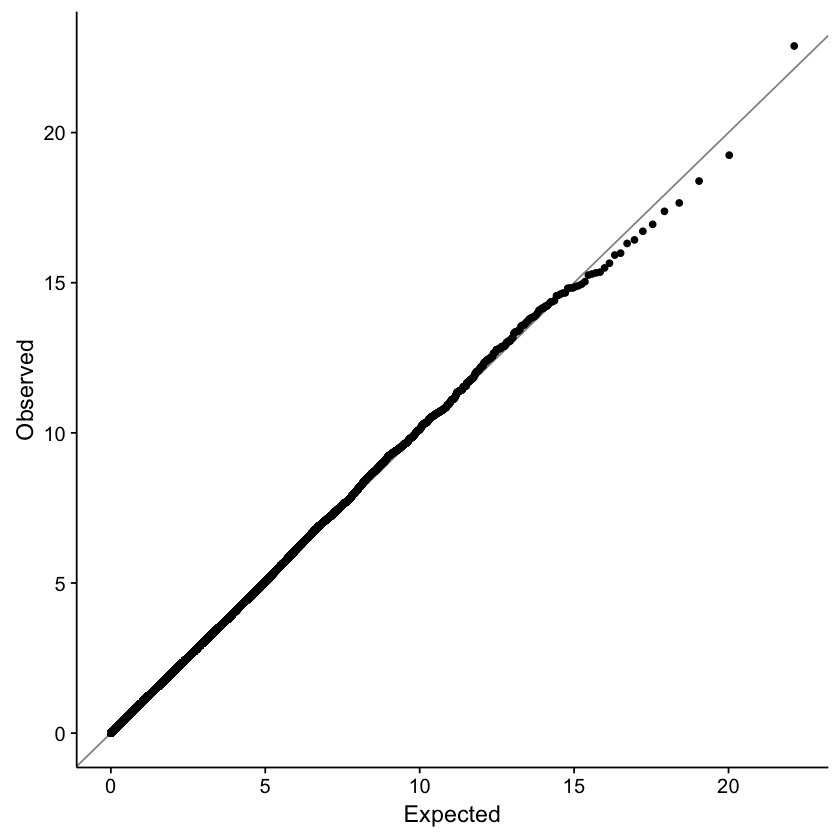

In [14]:
chi2 <- chi.squared(tests, df=1)

ggplot(as.data.frame(chi2), aes(sample = chi2)) +
    geom_qq(distribution = stats::qchisq, dparams = list(df = 1)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    labs(x = "Expected", y = "Observed")